# Reading EEG Data from events

Each events array has an `eegfile` field, which points to the directory that contains the associated 
EEG files. To read this data, you use the EEGReader class. 

Two other important classes for loading EEG data are the TalReader class, which loads information about 
the electrodes in ECoG subjects, and the MonopolarToBipolarMapper, which performs a bipolar rereferencing 
on ECoG data.

This notebook will go over loading EEG data from the three different CML formats.

In [1]:
%matplotlib inline
from ptsa.data.readers import BaseEventReader,EEGReader
from ptsa.data.readers import TalReader
from ptsa.data.filters import MonopolarToBipolarMapper
from matplotlib import pyplot as plt
import numpy as np
rhino_root='/Volumes/rhino_root'

Could not import MorletWaveletFilterCppLegacy (single-core C++ version of MorletWaveletFilter): cannot import name MorletWaveletTransform
You can still use MorletWaveletFilter


/Users/leond/miniconda2/envs/ptsa/lib/python2.7/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


### 1. pyFR data (and old RAM data)
First, we load the events, which are found on rhino in `/data/events/pyFR`:

In [2]:
events = BaseEventReader(filename=rhino_root+'/data/events/pyFR/BW001_events.mat',use_reref_eeg=False).read()
words = events[events.type=='WORD']

Next, we use the TalReader class to get information about the subject's electrodes. 

Like the other readers, the TalReader class has a `read()` method that will return a record array;
this one contains information about the location of each electrode. 
However, we're really only interested in two things: each electrode's number, and which electrodes 
are adjacent to each other.
Therefore, TalReader has two convenience methods, `get_monopolar_channels` and `get_bipolar_pairs`, 
specifically for this purpose.

In [3]:
tal_reader = TalReader(filename=rhino_root+'/data/eeg/BW001/tal/BW001_talLocs_database_bipol.mat')
channels = tal_reader.get_monopolar_channels()
channels

bpTalStruct


array(['001', '002', '003', '004', '005', '006', '007', '008', '009',
       '010', '011', '012', '013', '014', '015', '016', '017', '018',
       '019', '020', '021', '022', '023', '024', '025', '026', '027',
       '028', '029', '030', '031', '032', '033', '034', '035', '036',
       '037', '038', '039', '040', '041', '042', '043', '044', '045',
       '046', '047', '048', '049', '050', '051', '052', '053', '054',
       '055', '056', '057', '058', '059', '060', '061', '062', '063', '064'], 
      dtype='|S3')

Note the format of the channel array: a numpy array of 3-character strings.
 These are literally the suffixes of binary files, telling the EEGReader which files to load.

To load the EEG data into memory, we give the EEGReader the events and channels we want to load,
and the time around each event that we are interested in.
There is also a `buffer` parameter, that will add a buffer period to the timeseries we load at the beginning and the end.
If you add a buffer period, you should remove it afterwards with `remove_buffer()`. 

All of these use time in seconds as their unit.

In [4]:
eeg = EEGReader(events=events,channels=channels,start_time=0.0,end_time=1.0).read()
print(eeg)

/Users/leond/miniconda2/envs/ptsa/lib/python2.7/site-packages/ptsa/data/readers/ParamsReader.py:112: RuntimeWarning: Did not find "gain" in the params.txt file. Assuming gain=1.0
  warnings.warn('Did not find "gain" in the params.txt file. Assuming gain=1.0', RuntimeWarning)
/Users/leond/miniconda2/envs/ptsa/lib/python2.7/site-packages/ptsa/data/readers/BaseRawReader.py:66: RuntimeWarning: Could not find data format definition in the params file. Will read the file assuming data format is int16
  ' data format is int16', RuntimeWarning)


<xarray.TimeSeriesX (channels: 64, events: 444, time: 200)>
array([[[ -93.,  -96.,  -87., ...,   -4.,   25.,   38.],
        [-313., -296., -273., ...,  -99., -106.,  -90.],
        [  86.,   76.,   91., ...,  218.,  214.,  192.],
        ..., 
        [-291., -312., -287., ...,  -42.,  -24.,   -9.],
        [ -90.,  -89.,  -84., ...,   42.,   70.,   53.],
        [-123., -144., -135., ...,   -9.,  -27.,  -27.]],

       [[  -2.,   -3.,   10., ...,  -21.,   -8.,   28.],
        [-114., -107.,  -90., ...,  -40.,  -99., -158.],
        [ 140.,  131.,  212., ...,  -28.,  -18.,  -23.],
        ..., 
        [-160., -168., -129., ..., -130., -132., -136.],
        [  75.,   80.,   99., ...,   14.,   48.,   18.],
        [-186., -215., -203., ...,   23.,   11.,    7.]],

       [[  45.,   38.,   38., ...,   69.,  135.,  210.],
        [-261., -243., -218., ..., -125.,    2.,  129.],
        [ 134.,  163.,  261., ...,   -5.,   -8.,  -15.],
        ..., 
        [-247., -261., -226., ..., -127

The EEGReader returns a TimeSeriesX object, which is a subclass of xarray.DataArray.
The DataArray class provides an interface for multi-dimensional arrays with labelled axes; the TimeSeriesX object adds some additional convenience methods.

As an example of one might use a DataArray, let's plot the average voltage across all channels and events.



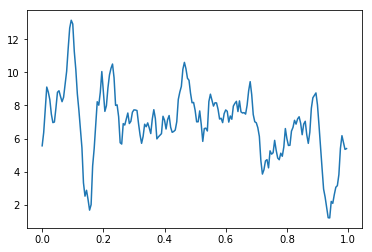

In [5]:
plt.plot(eeg.time,eeg.mean('channels').mean('events'))

In [6]:
print(eeg.coords)
print 
print
print(eeg.attrs)

Coordinates:
  * channels    (channels) |S3 '001' '002' '003' '004' '005' '006' '007' ...
    samplerate  float64 200.0
  * events      (events) (numpy.record, [('subject', 'S256'), ('session', '<i8'), ('list', '<i8'), ('type', 'S256'), ('item', 'S256'), ('itemno', '<i8'), ('recalled', '<i8'), ('mstime', '<i8'), ('msoffset', '<i8'), ('rectime', '<i8'), ('intrusion', '<i8'), ('eegfile', 'S256'), ('eegoffset', '<i8'), ('serialpos', '<i8')]) ('BW001', 1, -999, 'SESS_START', 'X', -999, -999, 683395115, -999, -999, -999, '/Volumes/rhino_root/data/eeg/BW001/eeg.noreref/BW001_24Jul02_0001', 2841, 0) ...
  * time        (time) float64 0.0 0.005 0.01 0.015 0.02 0.025 0.03 0.035 ...


OrderedDict([('samplerate', 200.0), ('gain', 1.0)])


"Data Coordinates" are marked with a star, and correspond to axes of our array. Other coordinates are not aligned to the data, but do persist under certain transformations. 

With ECoG data, it is usually more informative to look not at the voltage at each electrode, but at the difference across adjacent electrodes. 
The MonopolarToBipolarMapper class takes a list of which pairs are adjacent to each other, and returns a TimeSeriesX 
with the 'channels' dimension replaced by 'bipolar_pairs'.

In [7]:
bipolar_pairs = tal_reader.get_bipolar_pairs()
bipolar_eeg= MonopolarToBipolarMapper(time_series=eeg,bipolar_pairs=bipolar_pairs).filter()
bipolar_eeg

<xarray.TimeSeriesX (bipolar_pairs: 72, events: 444, time: 200)>
array([[[ -91.,  -93.,  -97., ...,   17.,   33.,   10.],
        [-199., -189., -183., ...,  -59.,   -7.,   68.],
        [ -54.,  -55., -121., ...,  246.,  232.,  215.],
        ..., 
        [-131., -144., -158., ...,   88.,  108.,  127.],
        [-165., -169., -183., ...,   28.,   22.,   35.],
        [  63.,   71.,   68., ...,  -32.,  -38.,  -34.]],

       [[ -47.,  -41.,  -28., ...,  -90., -143., -182.],
        [ 147.,  136.,  128., ...,   85., -101., -287.],
        [   6.,  -32.,  -49., ...,  -23.,  -10.,   -8.],
        ..., 
        [  87.,   93.,   97., ...,   -3.,   -6.,  -26.],
        [   1.,   14.,   51., ...,   85.,  194.,  255.],
        [-127., -135., -116., ...,  -31.,  -41.,  -34.]],

       [[ 103.,  103.,  104., ...,  255.,  449.,  625.],
        [  43.,   42.,   50., ..., -384., -319., -269.],
        [ 115.,  122.,  149., ...,  121.,  111.,  106.],
        ..., 
        [  30.,   41.,   55., ...,

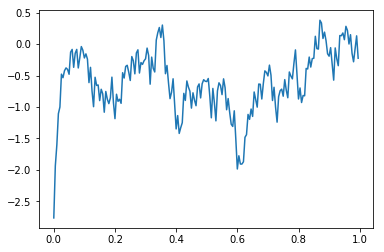

In [8]:
plt.plot(bipolar_eeg.time,bipolar_eeg.mean('bipolar_pairs').mean('events'))

We can use the `sel` method of DataArrays to filter the timeseries under consideration; for example, we can only look at the events of type "WORD":

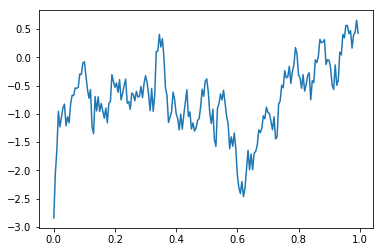

In [9]:
plt.plot(bipolar_eeg.time,bipolar_eeg.sel(events=bipolar_eeg.events.data['type']=='WORD').mean('bipolar_pairs').mean('events'))

This data seems like it's heavily contaminated by 60 Hz line noise. We can use the `filtered` method to filter out the 60 Hz component of the signal:

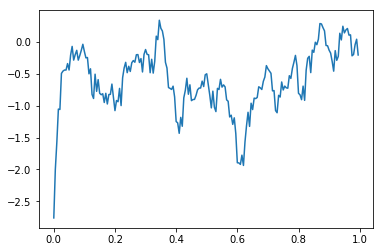

In [10]:
plt.plot(bipolar_eeg.time,bipolar_eeg.filtered([58.,62.]).mean('bipolar_pairs').mean('events'))

### 2. RAM data (new)

The new system for storing the RAM data stores the information about each subject's electrode montage in a file `pairs.json`,
which we can find using a JsonIndexReader

In [11]:
from ptsa.data.readers.IndexReader import JsonIndexReader
jr = JsonIndexReader(rhino_root+'/protocols/r1.json')
events = np.concatenate(
    [BaseEventReader(filename=f).read() for f in jr.aggregate_values('task_events',subject='R1111M',experiment='FR1')]
).view(np.recarray)
words = events[events.type=='WORD']
pairs_path = jr.get_value('pairs',subject='R1111M',experiment='FR1')

Once we have this path, we can create a TalReader object with it, and use that to load the list of channels and the list of bipolar pairs

In [13]:
tal_reader = TalReader(filename=pairs_path)
channels = tal_reader.get_monopolar_channels()
eeg = EEGReader(events=words,channels=channels,start_time=0.0,end_time=1.0).read()
eeg.coords

Coordinates:
  * channels    (channels) |S3 '001' '002' '003' '004' '005' '006' '007' ...
    samplerate  float64 500.0
  * events      (events) (numpy.record, [('session', '<i8'), ('eegoffset', '<i8'), ('protocol', 'S256'), ('intrusion', '<i8'), ('item_name', 'S256'), ('serialpos', '<i8'), ('rectime', '<i8'), ('stim_params', '<f8', (0,)), ('list', '<i8'), ('subject', 'S256'), ('eegfile', 'S256'), ('montage', 'S256'), ('experiment', 'S256'), ('recalled', '<i8'), ('msoffset', '<i8'), ('stim_list', '<i8'), ('item_num', '<i8'), ('mstime', '<i8'), ('is_stim', '<i8'), ('type', 'S256'), ('exp_version', 'S256')]) (2, 183362, 'r1', -999, 'JUICE', 1, -999, array([], dtype=float64), 1, 'R1111M', '/Volumes/rhino_root/protocols/r1/subjects/R1111M/experiments/FR1/sessions/2/ephys/current_processed/noreref/R1111M_FR1_2_26Jan16_1408', '0.0', 'FR1', 0, 1, 0, 138, 1453836066458, 0, 'WORD', '1.05') ...
  * time        (time) float64 0.0 0.002 0.004 0.006 0.008 0.01 0.012 0.014 ...

Coordinates:
  * bipolar_pairs  (bipolar_pairs) (numpy.record, [('ch0', 'S3'), ('ch1', 'S3')]) ('001', '002') ...
    samplerate     float64 500.0
  * events         (events) (numpy.record, [('session', '<i8'), ('eegoffset', '<i8'), ('protocol', 'S256'), ('intrusion', '<i8'), ('item_name', 'S256'), ('serialpos', '<i8'), ('rectime', '<i8'), ('stim_params', '<f8', (0,)), ('list', '<i8'), ('subject', 'S256'), ('eegfile', 'S256'), ('montage', 'S256'), ('experiment', 'S256'), ('recalled', '<i8'), ('msoffset', '<i8'), ('stim_list', '<i8'), ('item_num', '<i8'), ('mstime', '<i8'), ('is_stim', '<i8'), ('type', 'S256'), ('exp_version', 'S256')]) (2, 183362, 'r1', -999, 'JUICE', 1, -999, array([], dtype=float64), 1, 'R1111M', '/Volumes/rhino_root/protocols/r1/subjects/R1111M/experiments/FR1/sessions/2/ephys/current_processed/noreref/R1111M_FR1_2_26Jan16_1408', '0.0', 'FR1', 0, 1, 0, 138, 1453836066458, 0, 'WORD', '1.05') ...
  * time           (time) float64 0.0 0.002 0.004 0.006 0.008 0.01 0.012

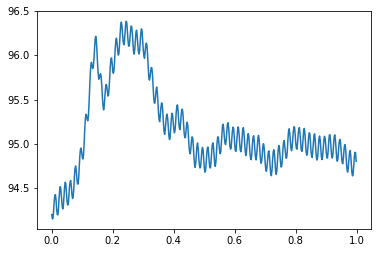

In [16]:
bipolar_eeg= MonopolarToBipolarMapper(time_series=eeg,bipolar_pairs=tal_reader.get_bipolar_pairs()).filter()
print(bipolar_eeg.coords)
plt.plot(bipolar_eeg.time,bipolar_eeg.mean('bipolar_pairs').mean('events'))

### 3. LTPFR/LTPFR2

In [17]:
events = BaseEventReader(filename=rhino_root+'/data/eeg/scalp/ltp/ltpFR2/behavioral/events/events_all_LTP093.mat',use_reref_eeg=True,common_root='data').read()
words = events[events.type=='WORD']

The main difference between reading scalp EEG data and ECoG data is that the scalp experiments have a fixed set of electrodes. 
We therefore construct the array of channel labels ourselves, rather than reading it with a TalReader.

The scalp EEG in the CML lab has 128 channels, but for purposes of speed we'll only load a few of them.

In [57]:
channels = np.array(['{:03}'.format(x) for x in range(20,30)])
channels

array(['020', '021', '022', '023', '024', '025', '026', '027', '028', '029'], 
      dtype='|S3')

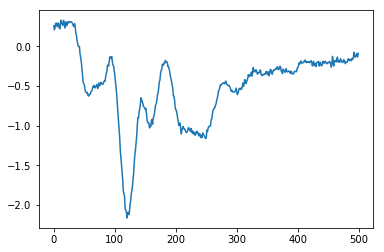

In [62]:
eeg = EEGReader(events=words,channels=channels,start_time=0.0,end_time=1.0).read()
plt.plot(eeg.mean('events').mean('channels'))